In [55]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [56]:
using DifferentialEquations
using Plots
import .JuliaMBD

In [57]:
## MSD

function MSD(;M = :M, D = :D, k = :k, g = 9.8)
    b = JuliaMBD.SubSystemBlock(:MSD)

    JuliaMBD.addparameter!(b, :M, M)
    JuliaMBD.addparameter!(b, :D, D)
    JuliaMBD.addparameter!(b, :k, k)
    JuliaMBD.addparameter!(b, :g, 9.8)

    in1 = JuliaMBD.Inport(:in1)
    JuliaMBD.add!(b, in1)

    out1 = JuliaMBD.Outport(:out1)
    JuliaMBD.add!(b, out1)

    constant1 = JuliaMBD.Constant()
    JuliaMBD.ConstSignal(:(M*g), constant1.env[:value])
    JuliaMBD.add!(b, constant1)

    gain1 = JuliaMBD.Gain()
    JuliaMBD.ConstSignal(:D, gain1.env[:K])
    JuliaMBD.add!(b, gain1)

    gain2 = JuliaMBD.Gain()
    JuliaMBD.ConstSignal(:k, gain2.env[:K])
    JuliaMBD.add!(b, gain2)

    gain3 = JuliaMBD.Gain()
    JuliaMBD.ConstSignal(:(1/M), gain3.env[:K])
    JuliaMBD.add!(b, gain3)

    int1 = JuliaMBD.Integrator(sin = JuliaMBD.OutPort(:int1sin), sout = JuliaMBD.OutPort(:int1sout))
    JuliaMBD.ConstSignal(0.0, int1.env[:initialcondition])
    JuliaMBD.add!(b, int1)

    int2 = JuliaMBD.Integrator(sin = JuliaMBD.OutPort(:int2sin), sout = JuliaMBD.OutPort(:int2sout))
    JuliaMBD.ConstSignal(:(M*g/k), int2.env[:initialcondition])
    JuliaMBD.add!(b, int2)

    sum1 = JuliaMBD.Add(signs=[:+, :+, :-, :-])
    JuliaMBD.add!(b, sum1)

    JuliaMBD.LineSignal(in1.env[:out], sum1.env[:in1])
    JuliaMBD.LineSignal(constant1.env[:out], sum1.env[:in2])
    JuliaMBD.LineSignal(gain1.env[:out], sum1.env[:in3])
    JuliaMBD.LineSignal(gain2.env[:out], sum1.env[:in4])
    JuliaMBD.LineSignal(sum1.env[:out], gain3.env[:in])

    JuliaMBD.LineSignal(gain3.env[:out], int1.env[:in])
    JuliaMBD.LineSignal(int1.env[:out], int2.env[:in])
    JuliaMBD.LineSignal(int1.env[:out], gain1.env[:in])

    JuliaMBD.LineSignal(int2.env[:out], gain2.env[:in])
    JuliaMBD.LineSignal(int2.env[:out], out1.env[:in])

    JuliaMBD.addscope!(b, :x, out1.env[:in])
    b
end

MSD (generic function with 1 method)

In [58]:
## test

function Test(;M = :M, D = :D, k = :k, f = :f, p_cycle = :p_cycle, p_width = :p_width)
    b = JuliaMBD.SubSystemBlock(:Test)

    JuliaMBD.addparameter!(b, :M, M)
    JuliaMBD.addparameter!(b, :D, D)
    JuliaMBD.addparameter!(b, :k, k)
    JuliaMBD.addparameter!(b, :f, f)
    JuliaMBD.addparameter!(b, :p_cycle, p_cycle)
    JuliaMBD.addparameter!(b, :p_width, p_width)
    JuliaMBD.addparameter!(b, :g, 9.8)

    msd = MSD(M=M, D=D, k=k)
    JuliaMBD.add!(b, msd)

    pulse = JuliaMBD.PulseGenerator()
    JuliaMBD.ConstSignal(:f, pulse.env[:amplitude])
    JuliaMBD.ConstSignal(:p_cycle, pulse.env[:period])
    JuliaMBD.ConstSignal(:p_width, pulse.env[:pulsewidth])
    JuliaMBD.ConstSignal(10.0, pulse.env[:phasedelay])
    JuliaMBD.add!(b, pulse)

    JuliaMBD.LineSignal(b.timeport, pulse.env[:time])
    JuliaMBD.LineSignal(pulse.env[:out], msd.env[:in1])

    JuliaMBD.addscope!(b, :F, pulse.env[:out])
    b
end

Test (generic function with 1 method)

In [59]:
b = Test(M=10, D=10, k=10, f=10, p_cycle=20, p_width=50)

"Block(Test)"

In [60]:
eval(JuliaMBD.expr_sfunc(b))
eval(JuliaMBD.expr_ofunc(b))
eval(JuliaMBD.expr_ifunc(b))
m = JuliaMBD.ODEModel(
    b,
    eval(JuliaMBD.expr_odemodel_ifunc(b)),
    eval(JuliaMBD.expr_odemodel_sfunc(b)),
    eval(JuliaMBD.expr_odemodel_ofunc(b))
);

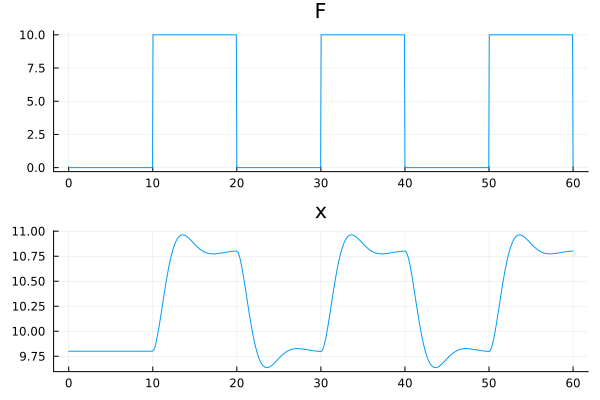

In [61]:
result = JuliaMBD.simulate(m, (0.0, 60.0))
plot(result)